# Fig. AR Climatology

Plot domain and variables used for EOF analysis

In [1]:
# Import Python modules
import os, sys
import numpy as np
import pandas as  pd
import xarray as xr
# plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import seaborn as sns
import cmocean.cm as cmo
import cmocean
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from pathlib import Path
from IPython.display import Image, display
from scipy.ndimage import gaussian_filter    # smoothing contour lines

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
from ar_funcs import preprocess_ar_area_subregions

In [2]:
xr.__version__

'0.15.1'

### Set up paths

In [3]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [4]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'


In [5]:
# label strings

ivt_units = 'kg m$^{-1}$ s$^{-1}$'

## Data

### 1) AR time series

In [6]:
# read netCDF with fraction of area AR covers each subregion
filename = path_to_data + 'CH1_generated_data/ar_catalog_v3_ERAI_fraction_HASIAsubregions.nc'
ds = xr.open_dataset(filename)

# Set dates
ds = ds.sel(time=slice('1979-01-01', '2018-12-31'))

## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=ds.to_dataframe(), thres=0.3)
# Show table
df.head()


,R01,R01_id,R02,R02_id,R03,R03_id,ar,location
time,,,,,,,,
1979-01-01,0.000000,NaN,0.0,NaN,0.0,NaN,0,NaN
1979-01-02,0.000000,NaN,0.0,NaN,0.0,NaN,0,NaN
1979-01-03,0.005102,14.0,0.0,NaN,0.0,NaN,0,NaN
1979-01-04,0.000000,NaN,0.0,NaN,0.0,NaN,0,NaN
1979-01-05,0.000000,NaN,0.0,NaN,0.0,NaN,0,NaN


In [ ]:
## create column of track id

df['tid'] = np.nan
idx = (df['R01_id'] > 0) | (df['R02_id'] > 0) | (df['R03_id'] > 0)
df.loc[idx, 'tid'] = df['R01_id']

### 2) ERA reanalysis

In [7]:
# Select lat/lon grid
lonmin = 45
lonmax = 110
latmin = 0
latmax = 50

### ERA5 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# open IVT anomaly data
filepath_pattern = path_to_data + 'ERA5/ivt/daily/out.era5*.nc'
f1 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(f1.nbytes / 1e9))

# Create new dataset to rename lat lon
era = xr.Dataset({'ivte': (['time', 'lat', 'lon'], f1['p71.162'].values),
                  'ivtn': (['time', 'lat', 'lon'], f1['p72.162'].values)},
                  coords={'time': (['time'], f1.time.values),
                          'lat': (['lat'], f1.latitude.values),
                          'lon': (['lon'], f1.longitude.values)})

era

ds size in GB 1.55



<xarray.Dataset>
Dimensions:  (lat: 101, lon: 131, time: 14610)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T09:00:00 ... 2018-12-31T09:00:00
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 45.0 45.5 46.0 46.5 47.0 ... 108.5 109.0 109.5 110.0
Data variables:
    ivte     (time, lat, lon) float32 121.644196 117.29042 ... 511.70425
    ivtn     (time, lat, lon) float32 91.39914 78.63043 ... -260.9256 -224.94096

### Select data subset

In [8]:
# Add AR time series to era5; set as coordinate variables
era['ar'] = ('time', df.ar)
era = era.set_coords('ar')

era['location'] = ('time', df.location)
era = era.set_coords('location')

# print dataset
print(era)

<xarray.Dataset>
Dimensions:   (lat: 101, lon: 131, time: 14610)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01T09:00:00 ... 2018-12-31T09:00:00
  * lat       (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * lon       (lon) float32 45.0 45.5 46.0 46.5 47.0 ... 108.5 109.0 109.5 110.0
    ar        (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    location  (time) object nan nan nan nan nan nan ... nan nan nan nan nan nan
Data variables:
    ivte      (time, lat, lon) float32 121.644196 117.29042 ... 511.70425
    ivtn      (time, lat, lon) float32 91.39914 78.63043 ... -224.94096


In [9]:
# Trim date range
start_date = '1979-12-01'
end_date = '2018-02-28'
idx = slice(start_date, end_date)
era = era.sel(time=idx)

# # Select DJF months
# idx = (era.time.dt.month >= 12) | (era.time.dt.month <= 2)
# era = era.sel(time=idx)

# Select AR days
idx = (era.ar >= 1)
era_ar = era.sel(time=idx)

# print results
print(era_ar)

<xarray.Dataset>
Dimensions:   (lat: 101, lon: 131, time: 1335)
Coordinates:
  * time      (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat       (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * lon       (lon) float32 45.0 45.5 46.0 46.5 47.0 ... 108.5 109.0 109.5 110.0
    ar        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    location  (time) object 'R03' 'R01' 'R01' 'R01' ... 'R03' 'R02' 'R01' 'R01'
Data variables:
    ivte      (time, lat, lon) float32 10.400909 10.845169 ... 31.925018
    ivtn      (time, lat, lon) float32 -20.965622 -19.556656 ... 60.000374


## Calculate climatology

In [10]:
# Mean IVT of AR days per season
# era_ar_clim = era_ar.mean(dim='time')
era_ar_clim = era_ar.groupby('time.season').mean(dim='time')

# Mean IVT of all days
era_clim = era.groupby('time.season').mean(dim='time')

In [14]:
ar_ds

<xarray.DataArray 'kidmap' (ens: 1, time: 59412, lev: 1, lat: 34, lon: 44)>
[88880352 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 45.0 46.5 48.0 49.5 51.0 ... 105.0 106.5 108.0 109.5
  * lat      (lat) float64 0.0 1.5 3.0 4.5 6.0 7.5 ... 43.5 45.0 46.5 48.0 49.5
  * lev      (lev) float64 1e+03
  * time     (time) datetime64[ns] 1979-01-01 ... 2019-08-31T18:00:00
  * ens      (ens) float64 1.0
Attributes:
    long_name:  Track ID
    units:      none

In [26]:
ar_filename = path_to_data + 'ar_catalog/globalARcatalog_ERA-Interim_1979-2019_v3.0.nc'
ds = xr.open_dataset(ar_filename)
ds = ar_ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

# count number of AR time steps per season
count_DJF = len(ar_ds.groupby('time.season').groups['DJF'])
count_MAM = len(ar_ds.groupby('time.season').groups['MAM'])
count_JJA = len(ar_ds.groupby('time.season').groups['JJA'])
count_SON = len(ar_ds.groupby('time.season').groups['SON'])

count_lst = [count_DJF, count_MAM, count_JJA, count_SON]

# count number of AR time steps per gridcell
ar_da = ar_ds.groupby('time.season').count(dim='time')

In [27]:
ar_da.sel[]

<xarray.DataArray 'kidmap' (ens: 1, season: 4, lev: 1, lat: 34, lon: 44)>
array([[[[[  55,   63,   63, ...,  154,  164,  124],
          [   3,    1,    0, ...,    1,    2,    5],
          [  10,    2,    0, ...,    2,    1,    2],
          ...,
          [ 976,  936,  900, ...,   21,   19,   22],
          [1074, 1017,  966, ...,   17,   13,   18],
          [1102, 1061, 1014, ...,   13,   13,   13]]],


        [[[ 166,  196,  206, ...,  204,  230,  159],
          [ 358,  376,  390, ...,  562,  612,  537],
          [ 557,  554,  558, ...,  833,  855,  801],
          ...,
          [ 965,  998,  994, ..., 1142, 1198, 1236],
          [1011, 1026, 1000, ..., 1123, 1191, 1221],
          [1105, 1110, 1072, ..., 1119, 1190, 1239]]],


        [[[   5,    7,   10, ...,   67,   96,   91],
          [   9,    8,   15, ...,  111,  141,  147],
          [  13,    7,   12, ...,  156,  160,  166],
          ...,
          [1036, 1062, 1071, ...,  165,  180,  200],
          [1020, 1078, 1093, ...,  138,  157,  169],
          [1035, 1037, 1069, ...,  135,  152,  177]]],


        [[[   7,    7,    8, ...,   82,   88,   80],
          [  14,   22,   22, ...,  227,  251,  225],
          [  23,   20,   27, ...,  340,  364,  368],
          ...,
          [1198, 1183, 1170, ...,  263,  287,  329],
          [1264, 1247, 1250, ...,  250,  257,  278],
          [1325, 1301, 1293, ...,  243,  265,  297]]]]])
Coordinates:
  * lon      (lon) float64 45.0 46.5 48.0 49.5 51.0 ... 105.0 106.5 108.0 109.5
  * lat      (lat) float64 0.0 1.5 3.0 4.5 6.0 7.5 ... 43.5 45.0 46.5 48.0 49.5
  * lev      (lev) float64 1e+03
  * ens      (ens) float64 1.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

## Create figure

In [41]:
ar_da.sel(season='DJF').squeeze()

<xarray.DataArray 'kidmap' (lat: 34, lon: 44)>
array([[  55,   63,   63, ...,  154,  164,  124],
       [   3,    1,    0, ...,    1,    2,    5],
       [  10,    2,    0, ...,    2,    1,    2],
       ...,
       [ 976,  936,  900, ...,   21,   19,   22],
       [1074, 1017,  966, ...,   17,   13,   18],
       [1102, 1061, 1014, ...,   13,   13,   13]])
Coordinates:
  * lon      (lon) float64 45.0 46.5 48.0 49.5 51.0 ... 105.0 106.5 108.0 109.5
  * lat      (lat) float64 0.0 1.5 3.0 4.5 6.0 7.5 ... 43.5 45.0 46.5 48.0 49.5
    lev      float64 1e+03
    ens      float64 1.0
    season   <U3 'DJF'

In [46]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subregion info 
# [ymin, xmin]
sr_xy = [[65, 30], [75, 25], [85, 20]]
# width of subregion
sr_width = [10, 10, 10]
# height of subregion
sr_height = [10, 10, 10]


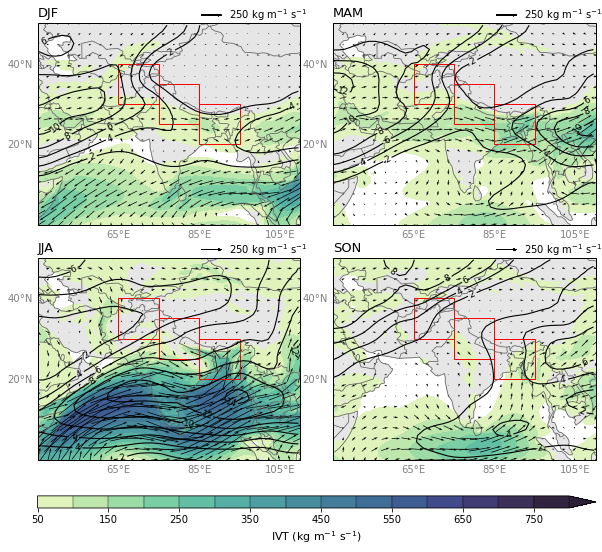

In [53]:
# Data for plotting
data = era_clim
lons = data.lon.values
lats = data.lat.values
count_lst = [count_DJF, count_MAM, count_JJA, count_SON]

# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')

# cmap setup
cmap = cmo.deep
clipcmap = cmocean.tools.crop_by_percent(cmap, 5, which='both', N=None)
cflevs = np.arange(50, 805, 50)
ssn_lst = ['DJF', 'MAM', 'JJA', 'SON']

# Loop for drawing each plot
for k, (ax, ssn) in enumerate(zip(axgr, ssn_lst)):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled
    # Average Seasonal Total
    uvec = data.ivte.sel(season=ssn).values
    vvec = data.ivtn.sel(season=ssn).values
    ivt = np.sqrt(uvec**2 + vvec**2)
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                    levels=cflevs,cmap=clipcmap, extend='max')
    
    
    # Contour Lines
    # Percent Frequency
    ar_lats = ar_da.lat.values
    ar_lons = ar_da.lon.values
    ar_count = ar_da.sel(season=ssn).squeeze()
    contr = (ar_count.values/count_lst[k])*100
    ar_smooth = gaussian_filter(contr, sigma=1.5)
    clevs = np.arange(2, 22, 2)
    cs = ax.contour(ar_lons, ar_lats, ar_smooth, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.1)
    kw_clabels = {'fontsize': 9, 'inline': True, 'inline_spacing': 8, 'fmt': '%d',
                  'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)
    
    # IVT vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs,
                  color='black', regrid_shape=20, pivot='middle', 
                  angles='xy', scale_units='xy', scale=50, units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.04, 250, r'250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                   coordinates='axes', fontproperties={'size': 10.0})
    
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    
    # Subtitles
    ax.set_title(ssn_lst[k], loc='left', fontsize=13)

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'ivt_clim_all_ssn' + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()